## Table Of Contents
 1. [Caricamento dei dati](#load)<br>
     1.1 [Grafici di esempio](#esempi)
 2. [Calcolo delle variabili di riassunto](#variabili)
 3. [Analisi esplorativa con `PCA`, `ICA`, `t-SNE`](#esplorativa)
 4. [Modello multinomiale](#multinomiale)<br>
     4.1 [Modello multinomiale penalizzato](#multinomiale-pen)
 5. [Analisi discriminante](#lda-qda)<br>
     5.1 [Analisi discriminante penalizzata](#da-pen)
 6. [Alberi di regressione](#tree)<br>
     6.1 [Alberi di regressione penalizzati](#tree-penalized)<br>

END. [Salvataggio dei dati](#save)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Funzioni base:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tqdm

# Font di LaTeX
# from matplotlib import rc

# Scikit-Learn
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# Funzioni custom
from funzioni import AbsMeanVarDeriv, Whiten,ScatterGroup, MatriceConfusione, indice_gini
from funzioni import tasso_errata_classificazione, grafico_metrica_iperparametro, grafico_metrica_iperparametri
from funzioni.grafici import grafico_importanza_variabili

# 3. Analisi esplorativa con `PCA`, `ICA`, `t-SNE` <a id=esplorativa> </a>

In [10]:
PATH_DATA = './PhonePi/data/'
FIG_PATH = './figure/'
DIR = [os.path.join(PATH_DATA, o) for o in os.listdir(PATH_DATA) 
                    if os.path.isdir(os.path.join(PATH_DATA,o))]
tipo=[(dir.split("/")[-1]).split(".")[0] for dir in DIR]
tipo=[dir.split("-")[0] for dir in tipo]

In [11]:
espl = pd.read_pickle("espl.pkl")
y = pd.read_pickle("y-2s.pkl")
X_train = pd.read_pickle("X_train.pkl")
y_train = pd.read_pickle("y_train.pkl")
X_val = pd.read_pickle("X_val.pkl")
y_val = pd.read_pickle("y_val.pkl")

In [5]:
# Sbiancamento dei dati
esplWh = Whiten().fit_transform(espl)

pca = PCA(n_components=2, random_state=42)
esplPCA = pca.fit_transform(esplWh)

ica = FastICA(n_components=2, random_state=42)
esplICA = ica.fit_transform(esplWh)

tsne = TSNE(n_components=2, random_state=42)
esplTSNE = tsne.fit_transform(esplWh)

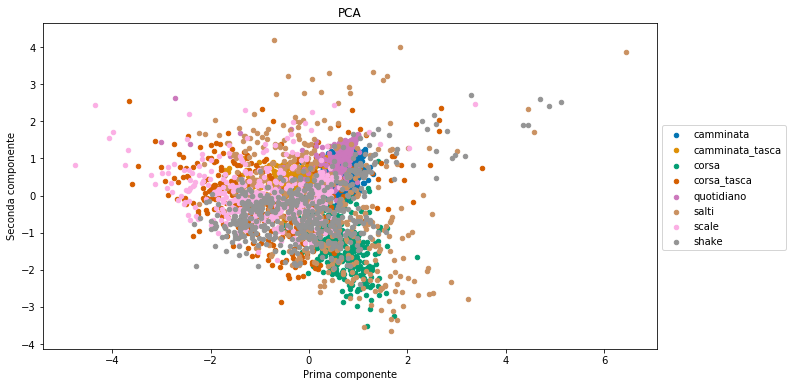

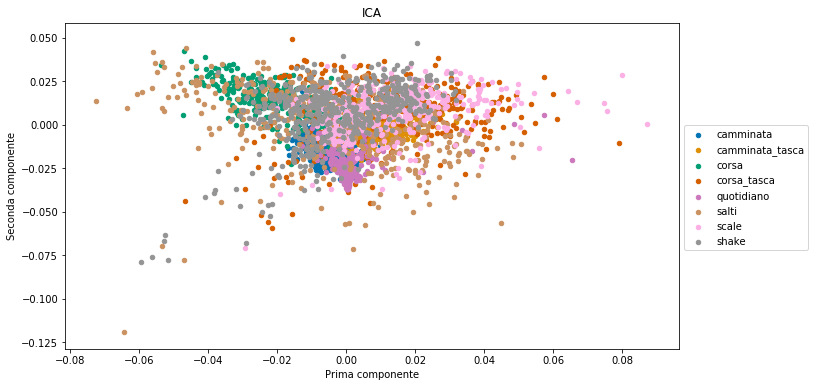

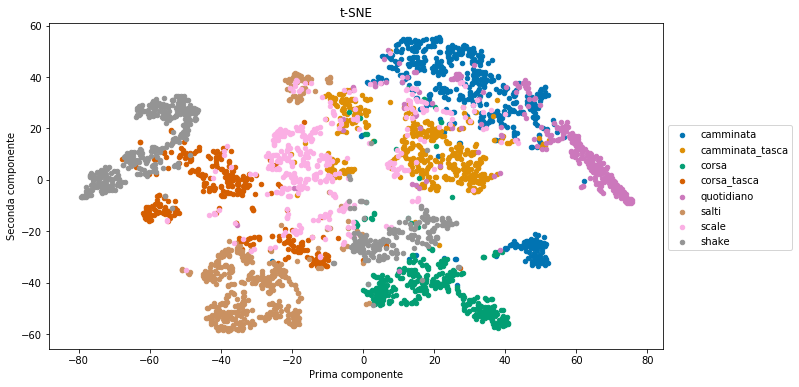

In [12]:
for title,dat in zip(["PCA","ICA","t-SNE"], [esplPCA, esplICA, esplTSNE]):
    fig, ax = ScatterGroup(pd.DataFrame(dat, columns=["Prima componente", "Seconda componente"]),
                       grp=y, palette="colorblind")
    fig.set_figwidth(11)
    fig.set_figheight(6)
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1,0.7))
    plt.savefig(FIG_PATH+title+".png", bbox_inches="tight", dpi=180)

# 4. Modello multinomiale <a id=multinomiale> </a>

/home/dede/anaconda3/envs/msbd/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Regressione multinomiale: 87.5% di accuratezza


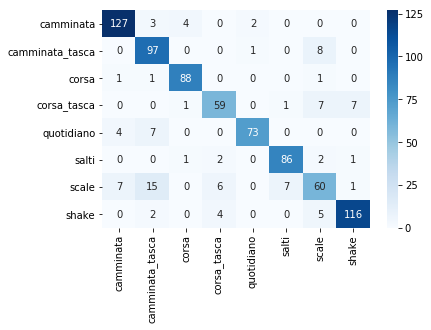

<Figure size 432x288 with 0 Axes>

In [13]:
glmMult = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, multi_class="multinomial",
                             solver="newton-cg", max_iter=300)
fit = glmMult.fit(X_train, y_train)
y_pred = fit.predict(X_val)

acc_mn = 100*accuracy_score(y_val, y_pred)
print("Regressione multinomiale: {:.1f}% di accuratezza".format(acc_mn))
MatriceConfusione(y_val, y_pred)
plt.savefig(FIG_PATH+"confusionMatrix-Mn.png", dpi=300, bbox_inches="tight")

## 4.1 Modello multinomiale penalizzato <a id=multinomiale-pen></a>

In [14]:
fit.classes_

array(['camminata', 'camminata_tasca', 'corsa', 'corsa_tasca',
       'quotidiano', 'salti', 'scale', 'shake'], dtype=object)

In [15]:
lab = y.unique()
lab.sort()
print(lab)

['camminata' 'camminata_tasca' 'corsa' 'corsa_tasca' 'quotidiano' 'salti'
 'scale' 'shake']


In [16]:
def PesiShakeMn(val):
    '''
    Funzione per modificare i pesi nel modello multinomiale
    
    Parameters
    ----------
    Modello : Funzione di classificazione (LDA o QDA)
    
    val : array di valori per cui dividere il peso base della classe shake
    '''

    lista_acc=[]
    lista_veri_positivi=[]
    for i in tqdm.tqdm(val):
        weights = y_train.value_counts()/y_train.value_counts().sum()
        weights["shake"]/=i
        weights/=weights.sum()
        w = {ind:weights[ind] for ind in weights.index}
        model = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, 
                               multi_class="multinomial",solver="newton-cg", max_iter=100, class_weight=w)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        lista_acc.append(100*accuracy_score(y_val, y_pred))
        lista_veri_positivi.append(100*(confusion_matrix(y_val, y_pred, labels=lab)[-1,-1]/confusion_matrix(y_val, y_pred,labels=lab)[:,-1].sum()))
        
    return lista_acc, lista_veri_positivi

In [17]:
import warnings
warnings.filterwarnings("ignore")
pesi = np.arange(1, 13, 0.5)
lista_acc_mn, lista_veri_positivi_mn = PesiShakeMn(val=pesi)

100%|██████████| 24/24 [00:26<00:00,  1.13s/it]


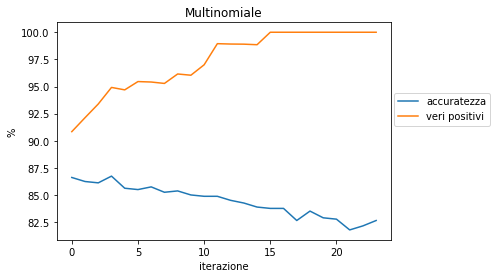

In [18]:
plt.plot(lista_acc_mn, label = "accuratezza")
plt.plot(lista_veri_positivi_mn, label = "veri positivi")
plt.title("Multinomiale")
plt.xlabel("iterazione")
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.31,0.7))
plt.show()

In [19]:
#-------------------- TODO ---------------------#
# Prendere il peso migliore per la multinomiale #
#-----------------------------------------------#
#w = ...


#glmMult = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, multi_class="multinomial",
#                              solver="newton-cg", max_iter=300, class_weight=w)
#fit = glmMult.fit(X_train, y_train)
# y_pred = fit.predict(X_val)

# acc_mn_pen = 100*accuracy_score(y_val, y_pred)
# print("Regressione multinomiale penalizzata: {:.1f}% di accuratezza".format(acc_mn_pen))
# MatriceConfusione(y_val, y_pred)
# plt.savefig(FIG_PATH+"confusionMatrix-Mn-penalizzata.png", dpi=300, bbox_inches="tight")

# 5. Analisi discriminante lineare e quadratica <a id=lda-qda> </a>

Accuratezza LDA: 77.1%


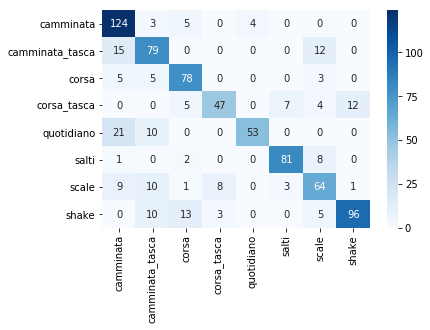

In [20]:
lda = LinearDiscriminantAnalysis()
X_lda=lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_val)
acc_lda = 100*accuracy_score(y_val, y_pred_lda)
print("Accuratezza LDA: {:.1f}%".format(acc_lda))
MatriceConfusione(y_val, y_pred_lda,nome_immagine=FIG_PATH+"confusionMatrix-LDA")

Accuratezza QDA: 87.9%


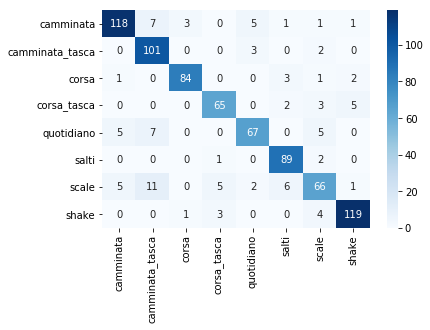

In [21]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA: {:.1f}%".format(acc_qda))
MatriceConfusione(y_val, y_pred_qda,nome_immagine=FIG_PATH+"confusionMatrix-QDA")

## 5.1 Analisi discriminante penalizzata <a id=da-pen> </a>

In [22]:
print(lda.classes_)

['camminata' 'camminata_tasca' 'corsa' 'corsa_tasca' 'quotidiano' 'salti'
 'scale' 'shake']


In [23]:
def PesiShakeDA(Modello, val):
    '''
    Funzione per modificare i pesi delle analisi discriminanti lineare e quadratica.
    
    Parameters
    ----------
    Modello : Funzione di classificazione (LDA o QDA)
    
    val : array di valori per cui dividere il peso base della classe shake
    '''

    lista_acc=[]
    lista_veri_positivi=[]
    w=[]
    for i in val:
        weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
        weights[-1] /= i
        weights = weights/weights.sum()
        w.append(weights[-1])
        model = Modello(priors=weights)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        lista_acc.append(100*accuracy_score(y_val, y_pred))
        lista_veri_positivi.append(100*(confusion_matrix(y_val, y_pred, labels=lab)[-1,-1]/confusion_matrix(y_val, y_pred,labels=lab)[:,-1].sum()))
        
    return w, lista_acc, lista_veri_positivi

### LDA e QDA penalizzate

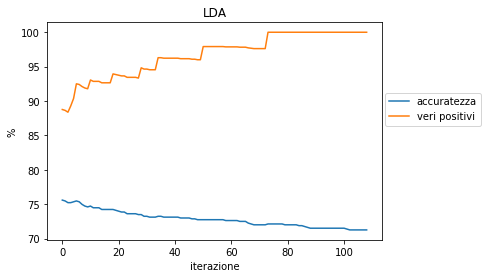

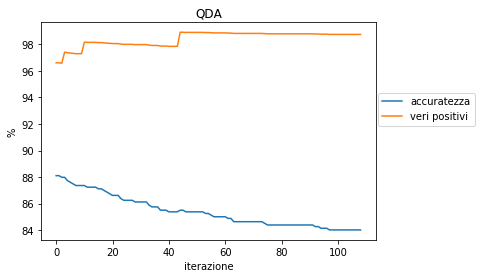

In [24]:
# in pratica per pesi crescenti assegnati alla classe dello shake si nota che la percentuale di veri positivi aumenta
# e l'accuratezza ovviamente diminuisce. Se vogliamo che l'errore di classificare shake qualcosa che non è shake sia nullo
# (o <0.01) scegliamo il primo peso che mi porta ad avere veri_positivi uguale a 100 (o 99) in modo da scegliere 
# il modello con l'accuratezza migliore fra quelli che non sbagliano lo shake

val = np.arange(1.1, 12, 0.1) # lista di divisori del peso per la classe

pesi_lda, lista_acc_lda, lista_veri_positivi_lda = PesiShakeDA(LinearDiscriminantAnalysis, val)
plt.plot(lista_acc_lda, label = "accuratezza")
plt.plot(lista_veri_positivi_lda, label = "veri positivi")
plt.title("LDA")
plt.xlabel("iterazione")
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.31,0.7))
plt.show()

pesi_qda, lista_acc_qda, lista_veri_positivi_qda = PesiShakeDA(QuadraticDiscriminantAnalysis, val)
plt.plot(lista_acc_qda, label = "accuratezza")
plt.plot(lista_veri_positivi_qda, label = "veri positivi")
plt.title("QDA")
plt.xlabel("iterazione")
plt.ylabel("%")
plt.legend(bbox_to_anchor=(1.31,0.7))
plt.show()

In [25]:
lista_veri_positivi_qda[-1]

98.75

In [26]:
lista_veri_positivi_lda=np.array(lista_veri_positivi_lda)
num_iterazione_lda=np.min(np.where(lista_veri_positivi_lda>99))
peso_shake_lda=np.arange(1.1,12,0.1)[num_iterazione_lda]
peso_shake_lda

8.400000000000006

In [27]:
lista_veri_positivi_qda=np.array(lista_veri_positivi_qda)
num_iterazione_qda=np.min(np.where(lista_veri_positivi_qda>98))
peso_shake_qda=np.arange(1.1,12,0.1)[num_iterazione_qda]
peso_shake_qda

2.100000000000001

Accuratezza LDA: 72.1%


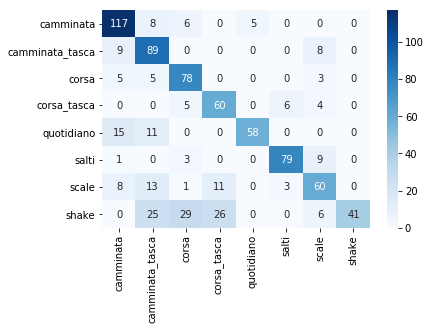

In [28]:
weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
weights[-1] /= peso_shake_lda
weights = weights/weights.sum()
lda = LinearDiscriminantAnalysis(priors=weights)
X_lda=lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_val)
acc_lda = 100*accuracy_score(y_val, y_pred_lda)
print("Accuratezza LDA: {:.1f}%".format(acc_lda))
MatriceConfusione(y_val, y_pred_lda,nome_immagine=FIG_PATH+"confusionMatrix-LDA-penalizzata")

Accuratezza QDA: 87.4%


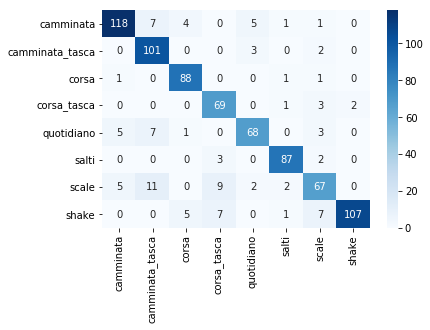

In [29]:
weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
weights[-1] /= peso_shake_qda
weights = weights/weights.sum()
qda = QuadraticDiscriminantAnalysis(priors=weights)
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA: {:.1f}%".format(acc_qda))
MatriceConfusione(y_val, y_pred_qda,nome_immagine=FIG_PATH+"confusionMatrix-QDA-penalizzata")

# 6. Alberi di regressione <a id=tree> </a>

Accuratezza DecisionTreeClassifier(): 85.38%


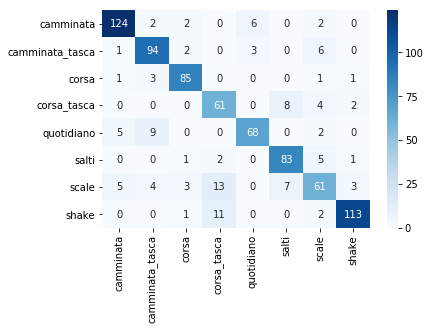

In [30]:
# Albero stimato sul training, senza vincoli (albero completo)
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_val)
acc_dtcFull = 100*accuracy_score(y_val, y_pred)

print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(acc_dtcFull))
MatriceConfusione(y_val, y_pred)
plt.show()

In [31]:
maxDepth = dtc.tree_.max_depth
minObs = len(X_train) // 2
print("Profondità dell'albero allenato senza restrizioni: {}".format(maxDepth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(minObs))

Profondità dell'albero allenato senza restrizioni: 18
Massimo numero minimo di osservazioni in una foglia: 1209


In [32]:
param_grid = ParameterGrid({
    'max_depth': np.arange(1, dtc.tree_.max_depth+1),
    'min_samples_leaf': 2 ** np.arange(int(np.log2(minObs) + 1)),
})
print(param_grid.param_grid)

[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18]), 'min_samples_leaf': array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024])}]


In [33]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc = DecisionTreeClassifier(random_state=42, **params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|██████████| 198/198 [00:01<00:00, 141.14it/s]

Primi 5:


,accuracy_score,max_depth,min_samples_leaf
0,0.853779,18,1
1,0.851301,17,1
2,0.847584,16,1
3,0.846344,11,1
4,0.845105,15,1


Ultimi 5:


,accuracy_score,max_depth,min_samples_leaf
193,0.28005,14,1024
194,0.28005,15,1024
195,0.28005,16,1024
196,0.28005,17,1024
197,0.28005,18,1024


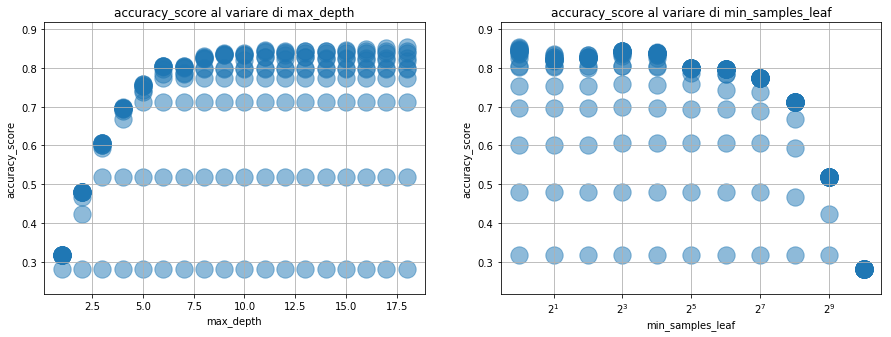

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
grafico_metrica_iperparametro(risultati, "max_depth", "accuracy_score", alpha=0.5)

plt.subplot(122)
grafico_metrica_iperparametro(risultati, "min_samples_leaf", "accuracy_score", alpha=0.5)
plt.xscale("log", basex=2)

plt.show()

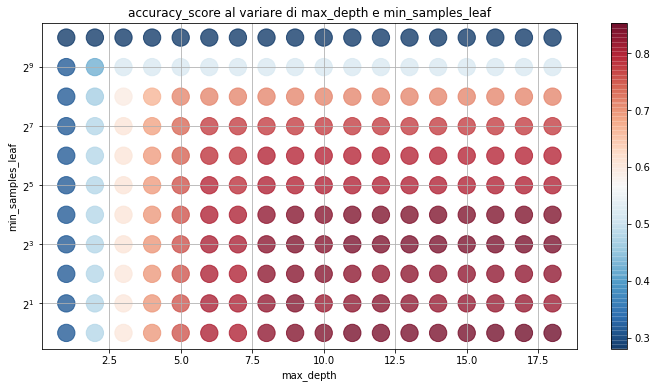

In [35]:
plt.figure(figsize=(12, 6))

grafico_metrica_iperparametri(risultati, "max_depth", "min_samples_leaf", "accuracy_score")
plt.yscale("log", basey=2)
plt.savefig(FIG_PATH + "iperparametri-Tree.png", dpi=200)
plt.show()

In [36]:
max_depth = risultati.loc[0, "max_depth"]
min_samples_leaf = risultati.loc[0, "min_samples_leaf"]

dtcTun = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
dtcTun.fit(X_train, y_train)

y_pred = dtcTun.predict(X_val)
acc_dtcTun = 100*accuracy_score(y_val, y_pred)
print("profondità ottimale:",max_depth)
print("numero ottimale minimo di unità per foglia:",min_samples_leaf)

profondità ottimale: 18
numero ottimale minimo di unità per foglia: 1


Accuratezza DecisionTreeClassifier(): 85.4%
Accuratezza DecisionTreeClassifier(max_depth=18, min_samples_leaf=1): 85.4%
[[124   2   2   0   6   0   2   0]
 [  1  94   2   0   3   0   6   0]
 [  1   3  85   0   0   0   1   1]
 [  0   0   0  61   0   8   4   2]
 [  5   9   0   0  68   0   2   0]
 [  0   0   1   2   0  83   5   1]
 [  5   4   3  13   0   7  61   3]
 [  0   0   1  11   0   0   2 113]]


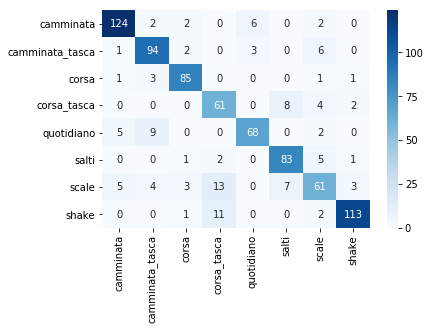

<Figure size 432x288 with 0 Axes>

In [37]:
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(acc_dtcFull))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, acc_dtcTun))
print(confusion_matrix(y_val, y_pred))

MatriceConfusione(y_val, y_pred)
plt.savefig(FIG_PATH + "confusionMatrix-Tree.png", dpi=300, bbox_inches="tight")
plt.show()

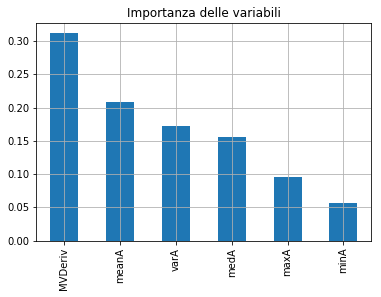

In [38]:
importanze = dtcTun.feature_importances_
variabili = espl.columns

grafico_importanza_variabili(importanze, variabili)
plt.savefig(FIG_PATH + "importance-Tree.png", dpi=300, bbox_inches="tight")
plt.show()

## 6.1 Alberi di regressione penalizzati  <a id=tree-penalized> </a>

In [39]:
dtc.classes_

array(['camminata', 'camminata_tasca', 'corsa', 'corsa_tasca',
       'quotidiano', 'salti', 'scale', 'shake'], dtype=object)

In [59]:
i=15
weights = y_train.value_counts()/y_train.value_counts().sum()
weights["shake"]/=i
weights/=weights.sum()
w = {ind:weights[ind] for ind in weights.index}

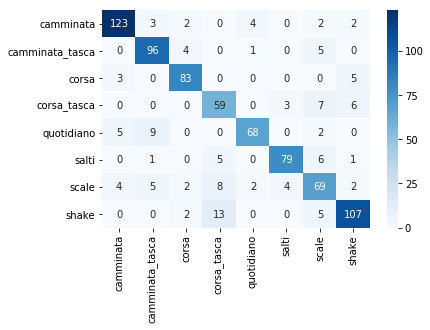

In [60]:
dtc = DecisionTreeClassifier(random_state=42,
                             class_weight=w)

dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_val)
MatriceConfusione(y_val, y_pred)

# END. Salvataggio dei risultati <a id=save> </a>

## Tabella accuracy in file LaTeX

In [ ]:
tableEnvBegin = "\\begin{table}[H]\n\\centering"
tableEnvEnd = "\end{table}"

In [ ]:
accuracy = pd.DataFrame([["Multinomiale", acc_mn],
             ["LDA", acc_lda],
             ["QDA", acc_qda],
             ["Decision Tree", acc_dtcFull],
             ["Optimized Decision Tree", acc_dtcTun]], columns=["Modello", "Accuratezza %"])

accuracy.sort_values("Accuratezza %", inplace=True)
caption='\\caption{Accuratezza per i modelli adattati.}\n'

In [ ]:
with open("./relazione/tex/accuracy-table.tex", mode="w") as file:
    file.write(tableEnvBegin + caption + accuracy.to_latex(index=False, float_format="%.2f", column_format="cc") + tableEnvEnd)

In [ ]:
# TODO: tabella accuracy - falsi positivi shake

### Crop delle immagini

In [ ]:
import platform
if platform.system() == "Linux":
    !mogrify -trim ./figure/*.png